In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
import mlflow.sklearn
import os
from pathlib import Path

# Scikit-learn Utilities
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, precision_score

# Konfigurasi Tampilan
%matplotlib inline
sns.set_style('whitegrid')

# --- 1. KONFIGURASI PATH ---
current_dir = Path(os.getcwd())
PROJECT_DIR = current_dir.parents[2] 
INPUT_FILE = PROJECT_DIR / 'data' / 'processed' / 'features.csv'
MLRUNS_DIR = PROJECT_DIR / 'mlruns' 

# --- 2. SETUP MLFLOW ---
if not MLRUNS_DIR.exists():
    MLRUNS_DIR.mkdir(parents=True, exist_ok=True)

mlflow.set_tracking_uri(f"file:///{MLRUNS_DIR.as_posix()}")
mlflow.set_experiment("Roodio_Mood_SVM_Experiment")

# --- 3. LOAD DATA ---
if not INPUT_FILE.exists():
    raise FileNotFoundError(f"File features.csv tidak ditemukan di {INPUT_FILE}")

df = pd.read_csv(INPUT_FILE)
X = df.drop('label', axis=1)
y = df['label']

le = LabelEncoder()
y_encoded = le.fit_transform(y)
label_mapping = dict(zip(le.transform(le.classes_), le.classes_))
print(f"✅ Label Mapping: {label_mapping}")

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)
print("✅ Setup Selesai. Siap Training SVM.")

2026/01/22 13:27:15 INFO mlflow.tracking.fluent: Experiment with name 'Roodio_Mood_SVM_Experiment' does not exist. Creating a new experiment.


✅ Label Mapping: {0: 'angry', 1: 'happy', 2: 'relaxed', 3: 'sad'}
✅ Setup Selesai. Siap Training SVM.


🚀 Sedang Melatih SVM (Mungkin butuh waktu)...
Fitting 5 folds for each of 12 candidates, totalling 60 fits

✅ Training Selesai!
🏆 Parameter Terbaik : {'classifier__C': 10, 'classifier__gamma': 'scale', 'classifier__kernel': 'rbf'}
📊 Akurasi Final     : 0.9424
⚖️ F1-Score (Macro)  : 0.9413


2026/01/22 13:57:46 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


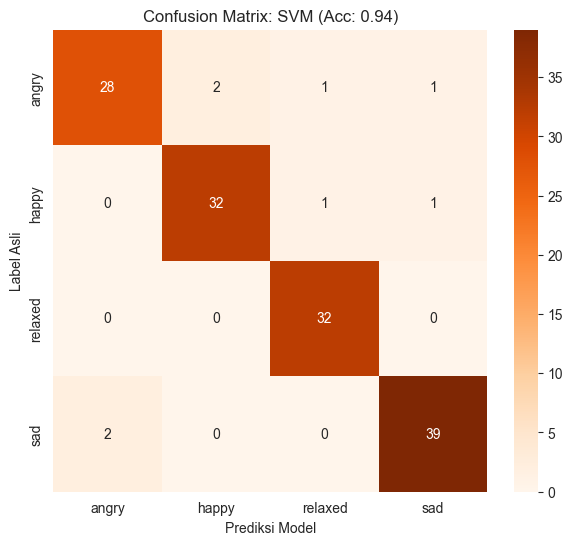

💾 Hasil SVM tersimpan lengkap di MLflow.


In [8]:
from sklearn.svm import SVC
from sklearn.metrics import f1_score, precision_score, recall_score

# --- 1. DEFINISI PIPELINE ---
pipeline_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', SVC(probability=True, random_state=42))
])

# --- 2. GRID SEARCH PARAMETER ---
param_grid_svm = {
    'classifier__C': [0.1, 1, 10],
    'classifier__kernel': ['linear', 'rbf'],
    'classifier__gamma': ['scale', 'auto']
}

# --- 3. EKSEKUSI TRAINING ---
run_name = "SVM_Tuning_Notebook"

with mlflow.start_run(run_name=run_name):
    print("🚀 Sedang Melatih SVM (Mungkin butuh waktu)...")
    
    grid = GridSearchCV(pipeline_svm, param_grid_svm, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
    grid.fit(X_train, y_train)
    
    # --- 4. EVALUASI ---
    best_model = grid.best_estimator_
    best_params = grid.best_params_
    
    y_pred = best_model.predict(X_test)
    
    # Hitung Metrik Lengkap
    test_acc = accuracy_score(y_test, y_pred)
    test_f1 = f1_score(y_test, y_pred, average='macro')
    test_prec = precision_score(y_test, y_pred, average='macro')
    test_recall = recall_score(y_test, y_pred, average='macro')
    
    print(f"\n✅ Training Selesai!")
    print(f"🏆 Parameter Terbaik : {best_params}")
    print(f"📊 Akurasi Final     : {test_acc:.4f}")
    print(f"⚖️ F1-Score (Macro)  : {test_f1:.4f}")
    
    # --- 5. LOGGING KE MLFLOW ---
    # Log Params
    clean_params = {k.replace("classifier__", ""): v for k, v in best_params.items()}
    mlflow.log_params(clean_params)
    
    # Log Metrics
    mlflow.log_metrics({
        "accuracy": test_acc,
        "f1_macro": test_f1,
        "precision_macro": test_prec,
        "recall_macro": test_recall
    })
    
    # Log Classification Report (Text File)
    report_text = classification_report(y_test, y_pred, target_names=le.classes_)
    with open("classification_report.txt", "w") as f:
        f.write(report_text)
    mlflow.log_artifact("classification_report.txt")
    if os.path.exists("classification_report.txt"): os.remove("classification_report.txt")

    # Log Model
    signature = mlflow.models.infer_signature(X_train, best_model.predict(X_train))
    mlflow.sklearn.log_model(best_model, "model", signature=signature, input_example=X_train.iloc[:1])
    
    # --- 6. VISUALISASI CM ---
    plt.figure(figsize=(7,6))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Oranges', 
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'Confusion Matrix: SVM (Acc: {test_acc:.2f})')
    plt.ylabel('Label Asli')
    plt.xlabel('Prediksi Model')
    
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")
    plt.show()
    if os.path.exists("confusion_matrix.png"): os.remove("confusion_matrix.png")
    
    print("💾 Hasil SVM tersimpan lengkap di MLflow.")


📊 LAPORAN EVALUASI SVM
              precision    recall  f1-score   support

       angry       0.93      0.88      0.90        32
       happy       0.94      0.94      0.94        34
     relaxed       0.94      1.00      0.97        32
         sad       0.95      0.95      0.95        41

    accuracy                           0.94       139
   macro avg       0.94      0.94      0.94       139
weighted avg       0.94      0.94      0.94       139

----------------------------------------
🏆 Macro F1-Score : 0.9413
🎯 Macro Precision: 0.9417
----------------------------------------


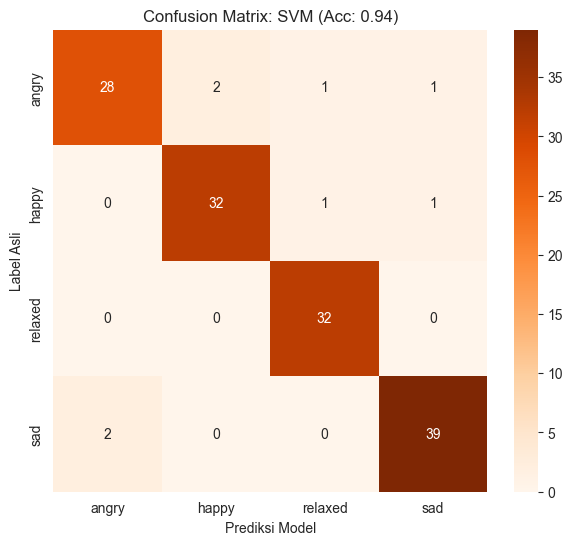

⚠️ KESALAHAN TERBESAR:
SVM sering salah mengira 'angry' sebagai 'happy' (2 kasus).


In [7]:
# --- EVALUASI SVM ---
print("\n" + "="*40)
print("📊 LAPORAN EVALUASI SVM")
print("="*40)

# 1. Classification Report
report = classification_report(y_test, y_pred, target_names=le.classes_)
print(report)

# 2. Metrik Global (Macro Avg)
macro_f1 = f1_score(y_test, y_pred, average='macro')
macro_prec = precision_score(y_test, y_pred, average='macro')

print("-" * 40)
print(f"🏆 Macro F1-Score : {macro_f1:.4f}")
print(f"🎯 Macro Precision: {macro_prec:.4f}")
print("-" * 40)

# 3. Analisis Kesalahan
cm = confusion_matrix(y_test, y_pred)

# Plot Heatmap
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title(f'Confusion Matrix: SVM (Acc: {test_acc:.2f})')
plt.ylabel('Label Asli')
plt.xlabel('Prediksi Model')
plt.show()

# Cek Kesalahan Terbesar
np.fill_diagonal(cm, 0) 
max_error_idx = np.unravel_index(np.argmax(cm), cm.shape)
true_label_err = le.classes_[max_error_idx[0]]
pred_label_err = le.classes_[max_error_idx[1]]
count_err = cm[max_error_idx]

print(f"⚠️ KESALAHAN TERBESAR:")
print(f"SVM sering salah mengira '{true_label_err}' sebagai '{pred_label_err}' ({count_err} kasus).")